In [1]:
import geopandas as gp
from shapely.geometry import shape, Polygon
import pandas as pd
import sys
sys.path.append('..')

from utils.sa import place_labels
from matplotlib import pyplot as plt

countries_raw = gp.read_file("./tmp/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
provinces_raw = gp.read_file("./tmp/myanmar_township_boundaries/myanmar_township_boundaries.shp")
rivers_raw = gp.read_file('./tmp/ne_10m_rivers_lake_centerlines_scale_rank/ne_10m_rivers_lake_centerlines_scale_rank.shp')
lakes_raw = gp.read_file('./tmp/ne_10m_lakes/ne_10m_lakes.shp')
urban_raw = gp.read_file('./tmp/ne_10m_urban_areas/ne_10m_urban_areas.shp')
populated_places_raw = gp.read_file('./tmp/ne_10m_populated_places_simple/ne_10m_populated_places_simple.shp')


step: 0/1000 t: 10000000.0 e: 329
step: 500/1000 t: 65704.83042414603 e: 148


In [2]:
bounding_box = (90,9,103,29)

countries = countries_raw.set_crs(epsg=4326)
provinces = provinces_raw.to_crs(epsg=4326)
rivers = rivers_raw.set_crs(epsg=4326)
urban = urban_raw.set_crs(epsg=4326)
lakes = lakes_raw.set_crs(epsg=4326)
populated_places = populated_places_raw.set_crs(epsg=4326)

map_extent = gp.GeoDataFrame(
    data={"geometry": [
        Polygon([
            (bounding_box[0], bounding_box[1]),
            (bounding_box[2], bounding_box[1]),
            (bounding_box[2], bounding_box[3]),
            (bounding_box[0], bounding_box[3]),
		])
	]},
    geometry="geometry",
    crs='EPSG:4326'
)

map_extent.to_file("./tmp/myanmar-conflict-me.geojson")

In [3]:
capitals = populated_places.loc[
    (populated_places["min_zoom"] < 6)
    & (populated_places["geometry"].x > bounding_box[0])
    & (populated_places["geometry"].x < bounding_box[2])
    & (populated_places["geometry"].y > bounding_box[1])
    & (populated_places["geometry"].y < bounding_box[3])
    ].copy()

label_points = place_labels(capitals, population_field="pop_max", time_limit=1000)
label_points.to_file("./tmp/myanmar-labels.geojson")

step: 0/1000 t: 10000000.0 e: 1344
step: 500/1000 t: 65704.83042414603 e: 1488


In [4]:
# Resolve duplicate shapeNames
seen = {}
for i, p in provinces.iterrows():
	name = p["TS"]
	if (p["TS"] in seen):
		print(f"Found duplicate: {name}")
		seen[name] += 1
		provinces.loc[i, "TS"] += "-" + str(seen[name])
	else:
		seen[name] = 1

provinces.to_file("./tmp/myanmar-provinces.geojson")

Found duplicate: Htantabin
Found duplicate: Minhla


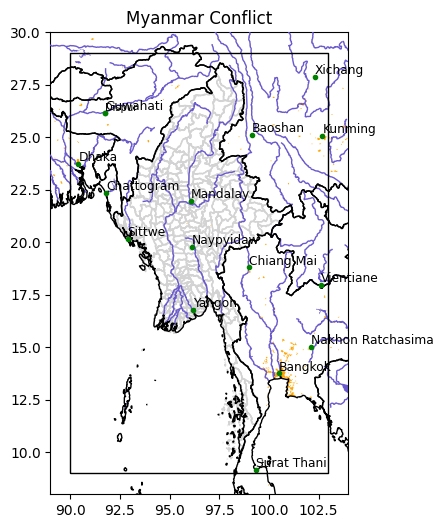

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(7,6))
plt.title("Myanmar Conflict")

ax.set_xlim(bounding_box[0] -1, bounding_box[2] + 1)
ax.set_ylim(bounding_box[1] -1, bounding_box[3] + 1)

countries.plot(ax=ax, color="none", edgecolor="black", zorder=10)
provinces.plot(ax=ax, color="none", edgecolor="lightgray", zorder=5)
urban.plot(ax=ax, color="orange")
rivers.plot(ax=ax, color='slateblue', lw=1, zorder=7)
lakes.plot(ax=ax, color="slateblue")
label_points.plot(ax=ax, marker=".", color='green', zorder=50)
map_extent.plot(ax=ax, color='none', edgecolor="black", lw=1, zorder=100)

for i, l in label_points.iterrows():
	plt.text(
        l.geometry.x,
        l.geometry.y,
        f"{l.label_text}",
        fontsize=l.font_size * 4.75,
        horizontalalignment=l.text_align_horizontal,
        verticalalignment="bottom",
		zorder=200
    )